# Imports

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn import preprocessing
from aux import *

import pandas as pd
pd.options.display.max_columns = 100

seed = 1997

# Lectura de datos

In [75]:
# Leemos la base de datos
col_names = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
for i in range(1,5):
    col_names.append('Wilderness_Area_' + str(i))
for i in range(1,41):
    col_names.append('Soil_Type_' + str(i))
col_names.append('Cover_Type')

dataset = pd.read_csv('covtype.data', header=None, names=col_names)

In [76]:
dataset.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Wilderness_Area_4,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [77]:
X = dataset.drop('Cover_Type', axis=1)
y = dataset['Cover_Type']
y.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

# Train, test, val split

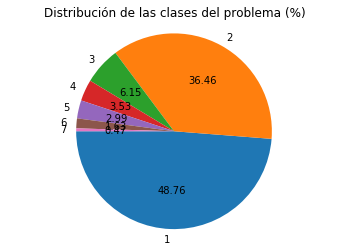

In [78]:
# Distribucion de las clases 
prop_class = y.value_counts(normalize=True)
pieLabels = ['1','2','3','4','5','6','7']
figureObject, axesObject = plt.subplots()
axesObject.pie(prop_class*100, labels=pieLabels, autopct='%1.2f', startangle=180)
axesObject.axis('equal')
plt.title("Distribución de las clases del problema (%)")
plt.show()

In [79]:
def balanced_split(dataset, size_train=2000):
    df_train = []
    df_test = []
    for i in range(1,8):
        df = dataset.loc[dataset['Cover_Type'] == i].sample(frac=1, random_state=1997)
        df_train.append(df.iloc[:size_train,:])
        df_test.append(df.iloc[size_train:, :])

    train = pd.concat(df_train)
    test = pd.concat(df_test)

    X_train = train.drop('Cover_Type', axis=1)
    y_train = train['Cover_Type']
    X_test = test.drop('Cover_Type', axis=1)
    y_test = test['Cover_Type']
    
    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = balanced_split(dataset, size_train=2160)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=11340, stratify=y_train, random_state=seed)

Separamos en train, vail y test.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=15120, stratify=y, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=11340, stratify=y_train, random_state=seed)

Número de elementos de cada clase en `train`.

In [81]:
y_train.value_counts()

2    5530
1    4135
3     698
7     400
6     339
5     185
4      53
Name: Cover_Type, dtype: int64

# Preprocesado

Definimos un `Pipeline` de preprocesado.

In [82]:
data_preprocess = Pipeline(
    [
        ("VT", VarianceThreshold()),
        ("Scaler", StandardScaler()),
        #("PCA", PCA(0.95)),
        #("Scaler2", StandardScaler()),
    ]
)

Preprocesamos el conjunto de entrenamiento y mostramos la matriz de correlación antes y después.

In [83]:
X_train_new = data_preprocess.fit_transform(X_train, y_train)
print(X_train.shape)
print(X_train_new.shape)
# se elimina el atributo Soil_Type_15 que tiene varianza 0

(11340, 54)
(11340, 53)


Matriz de correlación pre y post procesado (dígitos)


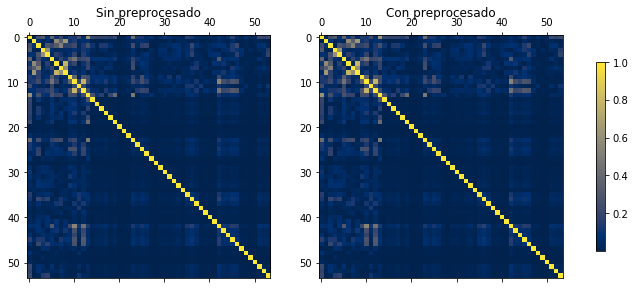

In [62]:
show_preprocess_correlation_matrix(X_train, X_train_new)

Preprocesamos validación y `test`.

In [84]:
X_train = X_train_new
X_val = data_preprocess.transform(X_val)
X_test = data_preprocess.transform(X_test)

# Modelos a considerar

Definimos un array con los modelos que vamos a considerar, se entrenarán y evaluarán en validación.

In [87]:
scorer = make_scorer(f1_score, average = "weighted")
#scorer = make_scorer(f1_score, average = "micro")

In [112]:
reg_values_lin = [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 100, 1000]
reg_values_svm = [1, 100, 250, 500, 750, 1000, 1250]

In [101]:
linear_models = []
linear_models += [
    (
        "Perceptron: \u03B1={}".format(a),
        Perceptron(alpha=a, penalty="l2", class_weight='balanced', random_state=seed, n_jobs=-1),
    )
    for a in reg_values_lin
]
linear_models += [
    (
        "RidgeClassifier: \u03B1={}".format(a),
        RidgeClassifier(alpha=a, random_state=seed, class_weight='balanced', max_iter=1000),
    )
    for a in reg_values_lin
]
linear_models += [
    (
        "Logistic regresion: C={}".format(c),
        LogisticRegression(
            C=c, multi_class="ovr", penalty="l2", solver='saga', class_weight='balanced', random_state=seed, n_jobs=-1
        ),
    )
    for c in reg_values_lin
]
linear_models += [
    (
        "SGD Classifier: \u03B1={}".format(a),
        SGDClassifier(alpha=a, class_weight='balanced', random_state=seed, n_jobs=-1)
    )
    for a in reg_values_lin
]

In [110]:
svm_models = []
svm_models += [
    (
        "SVM (3-poly): C={}".format(c),
        SVC(C = c, kernel='poly', degree=3)
    )
    for c in reg_values_svm
]
svm_models += [
    (
        "SVM (5-poly): C={}".format(c),
        SVC(C = c, kernel='poly', degree=5)
    )
    for c in reg_values_svm
]
svm_models += [
    (
        "SVM (rbf): C={}".format(c),
        SVC(C = c, kernel='rbf')
    )
    for c in reg_values_svm
]

In [113]:
rf_models = []
rf_models += [
    (
        "Random Forest: {} estimators, 1000 samples".format(n),
        RandomForestClassifier(n_estimators=n, max_samples=1000, class_weight="balanced", n_jobs=-1, random_state=seed)
    )
    for n in [100,500]
]
rf_models += [
    (
        "Random Forest: {} estimators".format(n),
        RandomForestClassifier(n_estimators=n, class_weight="balanced", n_jobs=-1, random_state=seed)
    )
    for n in [100,200]
]

# Elección de modelo

Hacemos `K-fold cross-validation` sobre cada uno de los conjuntos de modelos: lineal, knn y SVM. Y seleccionamos el mejor de cada uno.

In [104]:
best_linear = kfold_models(linear_models, X_train, y_train, seed, 
                           scorer, stratified=False, verbose=True)

Los modelos que se van a considerar son: 
	 Perceptron: α=0.001
	 Perceptron: α=0.01
	 Perceptron: α=0.1
	 Perceptron: α=0.5
	 Perceptron: α=1
	 Perceptron: α=2
	 Perceptron: α=5
	 Perceptron: α=10
	 Perceptron: α=100
	 Perceptron: α=1000
	 RidgeClassifier: α=0.001
	 RidgeClassifier: α=0.01
	 RidgeClassifier: α=0.1
	 RidgeClassifier: α=0.5
	 RidgeClassifier: α=1
	 RidgeClassifier: α=2
	 RidgeClassifier: α=5
	 RidgeClassifier: α=10
	 RidgeClassifier: α=100
	 RidgeClassifier: α=1000
	 Logistic regresion: C=0.001
	 Logistic regresion: C=0.01
	 Logistic regresion: C=0.1
	 Logistic regresion: C=0.5
	 Logistic regresion: C=1
	 Logistic regresion: C=2
	 Logistic regresion: C=5
	 Logistic regresion: C=10
	 Logistic regresion: C=100
	 Logistic regresion: C=1000
	 SGD Classifier: α=0.001
	 SGD Classifier: α=0.01
	 SGD Classifier: α=0.1
	 SGD Classifier: α=0.5
	 SGD Classifier: α=1
	 SGD Classifier: α=2
	 SGD Classifier: α=5
	 SGD Classifier: α=10
	 SGD Classifier: α=100
	 SGD Classifier: α=1000


In [111]:
best_svm = kfold_models(svm_models, X_train, y_train, seed, scorer,
                        stratified=False, verbose=True)

Los modelos que se van a considerar son: 
	 SVM (3-poly): C=1
	 SVM (3-poly): C=10
	 SVM (3-poly): C=100
	 SVM (3-poly): C=500
	 SVM (3-poly): C=800
	 SVM (3-poly): C=1000
	 SVM (3-poly): C=1200
	 SVM (3-poly): C=2000
	 SVM (3-poly): C=5000
	 SVM (5-poly): C=1
	 SVM (5-poly): C=10
	 SVM (5-poly): C=100
	 SVM (5-poly): C=500
	 SVM (5-poly): C=800
	 SVM (5-poly): C=1000
	 SVM (5-poly): C=1200
	 SVM (5-poly): C=2000
	 SVM (5-poly): C=5000
	 SVM (rbf): C=1
	 SVM (rbf): C=10
	 SVM (rbf): C=100
	 SVM (rbf): C=500
	 SVM (rbf): C=800
	 SVM (rbf): C=1000
	 SVM (rbf): C=1200
	 SVM (rbf): C=2000
	 SVM (rbf): C=5000


--> SVM (3-poly): C=1 <--
Score en K-fold: 0.685


--> SVM (3-poly): C=10 <--
Score en K-fold: 0.750


--> SVM (3-poly): C=100 <--
Score en K-fold: 0.765


--> SVM (3-poly): C=500 <--
Score en K-fold: 0.764


--> SVM (3-poly): C=800 <--
Score en K-fold: 0.762


--> SVM (3-poly): C=1000 <--
Score en K-fold: 0.763


--> SVM (3-poly): C=1200 <--
Score en K-fold: 0.763


--> SVM (3-poly)

In [114]:
best_rf = kfold_models(rf_models, X_train, y_train, seed, scorer,
                        stratified=True, verbose=True)

Los modelos que se van a considerar son: 
	 Random Forest: 100 estimators, 1000 samples
	 Random Forest: 500 estimators, 1000 samples
	 Random Forest: 100 estimators
	 Random Forest: 200 estimators


--> Random Forest: 100 estimators, 1000 samples <--
Score en K-fold: 0.725


--> Random Forest: 500 estimators, 1000 samples <--
Score en K-fold: 0.731


--> Random Forest: 100 estimators <--
Score en K-fold: 0.805


--> Random Forest: 200 estimators <--
Score en K-fold: 0.806



Mejor modelo: RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=1997)


Entrenamos y evaluamos cada modelo en el conjunto de validación, quedandonos con el mejor de ellos en `best_model`.

In [116]:
best_model = 0
best_model_score = 0

models = [best_linear, best_svm, best_rf]

for model in models:
    print(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    val_score = f1_score(y_val, y_pred, average='weighted')
    print("Validation Score: ", val_score)
    if best_model_score < val_score:
        best_model_score = val_score
        best_model = model

LogisticRegression(C=5, class_weight='balanced', multi_class='ovr', n_jobs=-1,
                   random_state=1997, solver='saga')


/home/pabloac31/anaconda3/envs/AA/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pabloac31/anaconda3/envs/AA/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pabloac31/anaconda3/envs/AA/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pabloac31/anaconda3/envs/AA/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation Score:  0.652888600055249
SVC(C=500)
Validation Score:  0.7792293994413523
RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=1997)
Validation Score:  0.811343723715531


El mejor modelo ha resultado:

In [117]:
print(best_model)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=1997)


# Predicción

Predecimos los valores de `test` con dicho modelo.

In [118]:
y_pred = best_model.predict(X_test)
print("F1-score obtenido: {:.2f}".format(f1_score(y_test, y_pred, average='weighted')))

F1-score obtenido: 0.82


Mostramos la curva de aprendizaje obtenida por el modelo de la siguiente forma, empezamos tomando el $10\%$ del conjunto de `train` y hacemos `cross-validation` con dicho conjunto, repetimos el proceso aumentando el porcentage del conjunto utilizado hasta llegar al $100\%$.

<module 'matplotlib.pyplot' from '/home/pabloac31/anaconda3/envs/AA/lib/python3.7/site-packages/matplotlib/pyplot.py'>

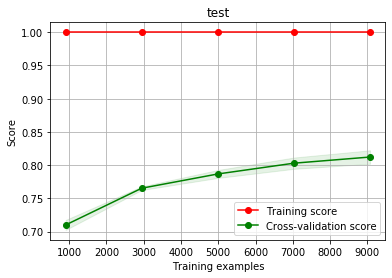

In [119]:
plot_learning_curve(best_model, "test", X_train, y_train)

Mostramos la matriz de confusión de los datos

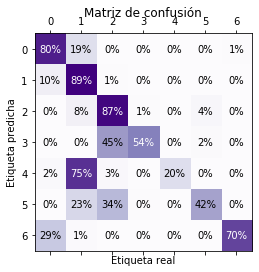

In [120]:
"""Muestra matriz de confusión de la base de datos de dígitos."""
show_confusion_matrix(y_test, y_pred, 7)

In [121]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.83      0.80      0.82    206327
           2       0.82      0.89      0.85    275928
           3       0.75      0.87      0.81     34824
           4       0.81      0.54      0.65      2676
           5       0.87      0.20      0.32      9246
           6       0.76      0.42      0.54     16915
           7       0.90      0.70      0.79     19976

    accuracy                           0.82    565892
   macro avg       0.82      0.63      0.68    565892
weighted avg       0.82      0.82      0.82    565892



In [122]:
y_test.value_counts()

2    275928
1    206327
3     34824
7     19976
6     16915
5      9246
4      2676
Name: Cover_Type, dtype: int64

# Prueba ensemble

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100000, stratify=y, random_state=seed)

In [123]:
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier

In [124]:
ec = BalancedRandomForestClassifier(n_estimators=1000, sampling_strategy='not minority', class_weight='balanced', random_state=seed, n_jobs=-1)
ec.fit(X_train, y_train) 

BalancedRandomForestClassifier(class_weight='balanced', n_estimators=1000,
                               n_jobs=-1, random_state=1997,
                               sampling_strategy='not minority')

In [70]:
y_pred = ec.predict(X_test)